In [1]:
import random
import math

import numpy as np
import pandas as pd
from pandas import DataFrame, Series


In [2]:
class EpsGreedyPolicy(object):
    def __init__(self, eps):
        self.eps = eps
        
    def select_action(self, n, step, q):
        if np.random.rand() < self.eps:
            return random.randint(0, n-1)
        max_q = max(q)
        max_action_indexes = [i for i, value in enumerate(q) if value == max_q]
        return random.choice(max_action_indexes)
    
class EpsDiscountedGreedyPolicy(object):
    def __init__(self):
        pass
        
    def select_action(self, n, step, q):
        if np.random.rand() < 1 / float(step+1):
            return random.randint(0, n-1)
        max_q = max(q)
        max_action_indexes = [i for i, value in enumerate(q) if value == max_q]
        return random.choice(max_action_indexes)
    
    
class GreedyPolicy(EpsGreedyPolicy):
    def __init__(self):
        super(GreedyPolicy, self).__init__(eps=0)
        
class GibbsSoftmaxPolicy(object):
    def __init__(self, theta):
        self.theta = theta
    
    def select_action(self, n, step, q):
        den = sum(math.exp(value/self.theta) for value in q)
        pbb_mass = 0
        r = np.random.rand()
        for action_idx, value in enumerate(q):
            pbb = math.exp(value/self.theta)/den
            pbb_mass += pbb
            if r < pbb_mass:
                return action_idx
        raise ValueError
    
class SimpleBanditFactory(object):
    class SimpleBandit(object):
        def __init__(self, mu, variance):
            self.mu = mu
            self.variance = variance
        def play(self):
            return np.random.normal(self.mu, math.sqrt(self.variance))
    
    def __init__(self, mu, variance, bandit_value_variance):
        self.mu = mu
        self.variance = variance
        self.bandit_value_variance = bandit_value_variance
        self.num_bandits = 0
        self.best_action_indexes = []
        self.best_action_mu = None
        
    def generate(self):
        bandit_mu = np.random.normal(self.mu, math.sqrt(self.variance))
        if self.best_action_mu is None or bandit_mu > self.best_action_mu:
            self.best_action_mu = bandit_mu
            self.best_action_indexes = [self.num_bandits]
        elif bandit_mu == self.best_action_mu:
            self.best_action_indexes.append(self.num_bandits)
        bandit = self.SimpleBandit(mu=bandit_mu, variance=self.bandit_value_variance)
        self.num_bandits += 1
        return bandit
    
    def is_optimal_action(self, action_idx):
        return action_idx in self.best_action_indexes
        
        

In [3]:
class BanditTask(object):
    """
    Represents n-armed bandit task
    """
    def __init__(self, num_bandits, bandit_factory):
        self.num_bandits = num_bandits
        self.bandit_factory = bandit_factory
        self.bandits = [bandit_factory.generate() for _ in xrange(self.num_bandits)]
        
    def _play_once(self, step, policy):
        """
        Plays n-armed bandit task once using a given policy
        and updates value action for the selected action with the observed reward
        """
        action_idx = policy.select_action(
            n=self.num_bandits, 
            step=step,
            q=self.q)
        reward = self.bandits[action_idx].play()
        self.history_rewards.append(reward)
        self.num_selected[action_idx] += 1
        self.sum_rewards[action_idx] += reward
        self.q[action_idx] = self.sum_rewards[action_idx] / float(self.num_selected[action_idx])
        optimal_action_selected = self.bandit_factory.is_optimal_action(action_idx)
        self.history_optimal_action_selected.append(optimal_action_selected)
    
    def _init_simulation(self, initial_action_value):
        """
        Initializes all variables that are required for the simulation:
        - initial action values
        - number of times action was selected
        - summary reward of actions
        - history_rewards is a history of all obtained rewards
        -
        """
        
        self.q = [initial_action_value for _ in xrange(self.num_bandits)]
        self.num_selected = [0 for _ in xrange(self.num_bandits)]
        self.sum_rewards = [0 for _ in xrange(self.num_bandits)]
        self.history_rewards = []
        self.history_optimal_action_selected = []
        
    def run_simulation(self, num_plays, policy, initial_action_value):
        """
        Runs the n-armed bandit tasks for num_plays number of plays with eps-greedy policy
        and initial_action_value denoting the initial action value of all actions (bandits)
        
        policy: a function that takes 3 parameters: number of bandits, play number, current action value estimates
        and returs a single integer denoting the index of selected action, 
        i.e. integer in range [0, num_bandits-1]
        
        returns a tuple:
        - list of all history rewards obtained
        - list of bool variables indicating whether an optimal action was selected during whole history
        """
        
        self._init_simulation(initial_action_value=initial_action_value)
        
        for step in xrange(num_plays):
            self._play_once(step, policy)
        return self.history_rewards, self.history_optimal_action_selected
            

In [4]:
%%time

POLICIES = {
    "gibbs-softmax-0.1": GibbsSoftmaxPolicy(theta=0.1),
    "greedy": GreedyPolicy(),
    "eps-greedy-0.1": EpsGreedyPolicy(eps=0.1),
    "eps-greedy-0.01": EpsGreedyPolicy(eps=0.01),
    "eps-discounted": EpsDiscountedGreedyPolicy(),
}
NUM_SIMULATIONS = 2000
NUM_PLAYS = 1000
NUM_BANDITS = 10
INITIAL_ACTION_VALUE = 0
results = {}

for policy_name, policy in POLICIES.items():
    all_history_rewards = []
    all_optimal_action_selected = []
    for simuliation_idx in xrange(NUM_SIMULATIONS):
        bandit_factory = SimpleBanditFactory(mu=0.0, variance=1.0, bandit_value_variance=1.0)
        task = BanditTask(
            num_bandits=NUM_BANDITS,
            bandit_factory=bandit_factory)
        history_rewards, history_optimal_action_selected = task.run_simulation(
            num_plays=NUM_PLAYS, policy=policy, initial_action_value=INITIAL_ACTION_VALUE)
        all_history_rewards.append(history_rewards)
        all_optimal_action_selected.append(history_optimal_action_selected)
    results[policy_name] = (
        DataFrame(all_history_rewards),
        DataFrame(all_optimal_action_selected),
    )


CPU times: user 1min 27s, sys: 735 ms, total: 1min 27s
Wall time: 1min 28s


Text(0.5,0,'Plays')

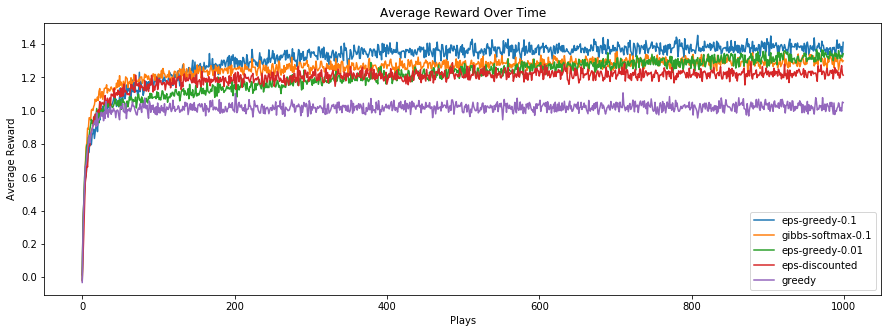

In [8]:
for policy_name, (history_rewards, _) in results.items():
    ax = history_rewards.mean(axis=0).plot(legend=True, figsize=(15,5))
legend = ax.legend()
for i in xrange(len(results)):
    legend.get_texts()[i].set_text(results.keys()[i])
ax.set_title('Average Reward Over Time')
ax.set_ylabel("Average Reward")
ax.set_xlabel("Plays")
    


Text(0.5,0,'Plays')

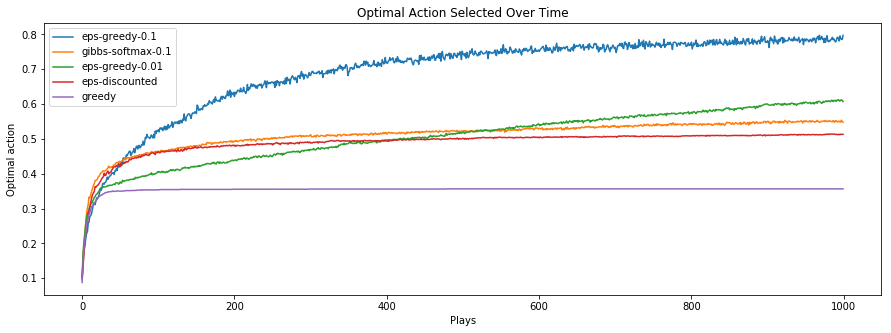

In [9]:
for policy_name, (_, history_optimal_action_selected) in results.items():
    ax = history_optimal_action_selected.mean(axis=0).plot(legend=True, figsize=(15,5))
legend = ax.legend()
for i in xrange(len(results)):
    legend.get_texts()[i].set_text(results.keys()[i])
ax.set_title('Optimal Action Selected Over Time')
ax.set_ylabel('Optimal action')
ax.set_xlabel("Plays")